In [1]:
!pip install faiss-cpu torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 49.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found

In [15]:
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import torch

import torch.nn as nn

import os

import faiss
import numpy as np

In [20]:
from transformers import CLIPImageProcessor, CLIPVisionModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-large-patch14")
model.eval()

def get_embeddings(image_path):
    image = Image.open(image_path).convert('RGB')
    tensor = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model(**tensor)
        embedding = output.pooler_output
        embedding = nn.functional.normalize(embedding, p=1, dim=-1)

    return embedding.squeeze().cpu().numpy()

In [38]:
# model w/out last layer
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def extract_feature(image_path):
    image = Image.open(image_path).convert('RGB')
    tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        feature = model(tensor).squeeze().numpy()


    return feature / np.linalg.norm(feature)

In [21]:
from tqdm import tqdm

image_folder = '/kaggle/input/homework6-2/dataset'
image_names = [f for f in os.listdir(image_folder) if f.endswith('.png')]

features = []


for path in tqdm(image_names, desc="Processing images"):
    feat = get_embeddings(os.path.join(image_folder, path)) 
    features.append(feat)

dim_features = features[0].shape[0]

indexes = faiss.IndexFlatL2(dim_features)

indexes.add(np.stack(features))

Processing images: 100%|██████████| 9605/9605 [08:32<00:00, 18.75it/s]


Похожие изображения:
0044.png


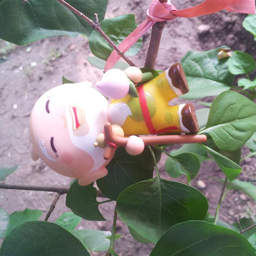

8447.png


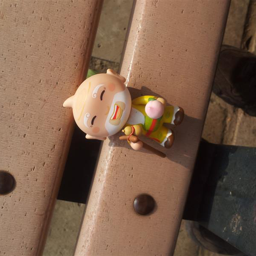

1967.png


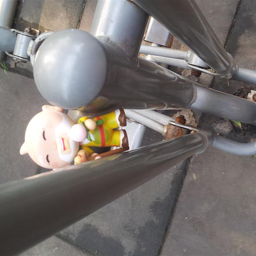

5506.png


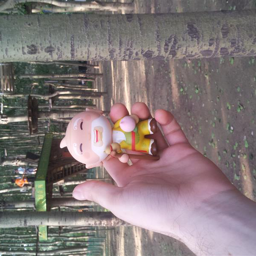

8832.png


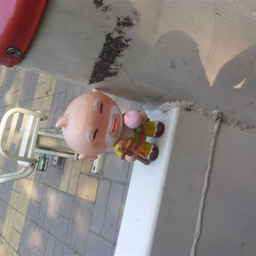

9564.png


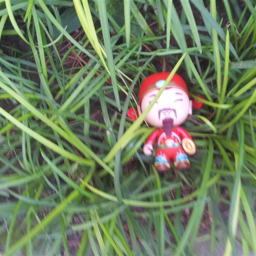

4392.png


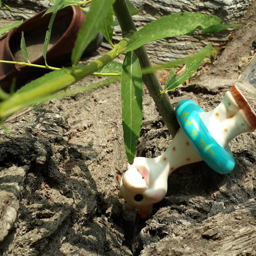

In [23]:
# Извлечем признаки для запроса
query_image = '/kaggle/input/homework6-2/dataset/0044.png'
query_vector = get_embeddings(query_image).astype('float32').reshape(1, -1)

# Найдём top-6 ближайших
k = 7
distances, indices = indexes.search(query_vector, k)

# Покажем результаты
print("Похожие изображения:")
for idx in indices[0]:
    print(image_names[idx])
    img = Image.open(os.path.join(image_folder, image_names[idx]))
    display(img)

In [24]:
# Создаем топ-6 ближайших для каждого изображения
k = 7
dict_sim = {}

for idx_t, feature in enumerate(features):
    distances, indices = indexes.search(feature.reshape(1, -1), k)
    idxs_sim = []
    for idx in indices[0]:
        if idx != idx_t:
            idxs_sim.append(image_names[idx])

    dict_sim[image_names[idx_t]] = idxs_sim      
        

In [25]:
for key, value in dict_sim.items():
    if len(value) > 6:
        value = value[:-1]

In [26]:
# Формируем таблицу в нужном формате
data = []
for key, value in dict_sim.items():
    st = " ".join(str(x) for x in value)
    data.append([key, st])

data = sorted(data)
data.insert(0, ['filename','ranking'])

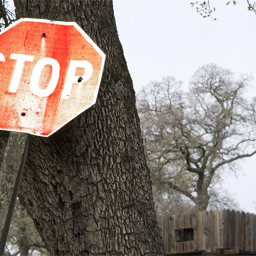

Похожие изображения:
6722.png


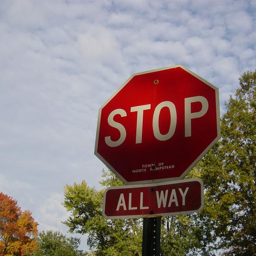

7198.png


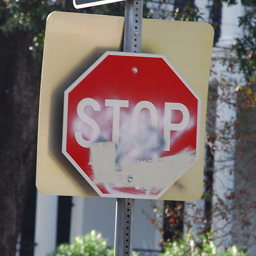

8793.png


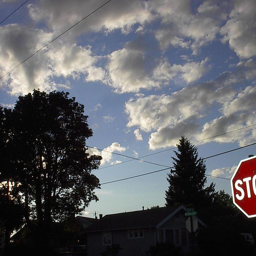

4668.png


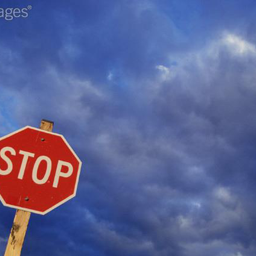

5141.png


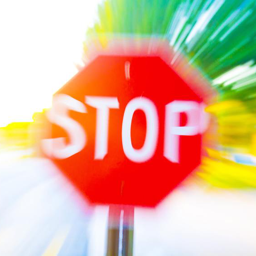

6770.png


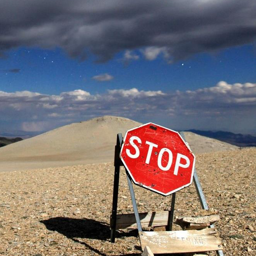

In [27]:
# Смотрим случайный результат
import random
n = random.randint(1, 9605)
img_name = data[n][0] 
img = Image.open(os.path.join(image_folder, img_name))
display(img)
print("Похожие изображения:")
for im in data[n][1].split():
    print(im)
    img = Image.open(os.path.join(image_folder, im))
    display(img)

In [28]:
# Записываем ответ в файл
import csv

name = 'submission.csv'
with open(name, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)


Target 1010.png


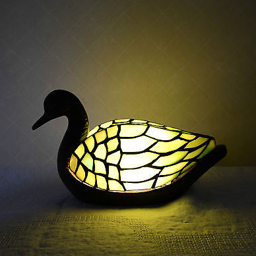

1880.png


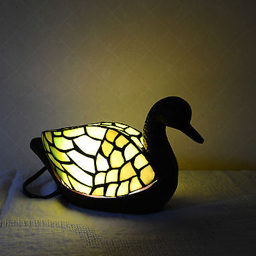

8766.png


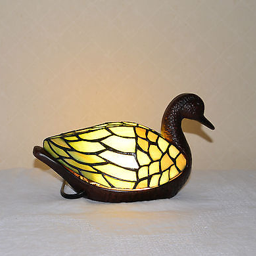

7020.png


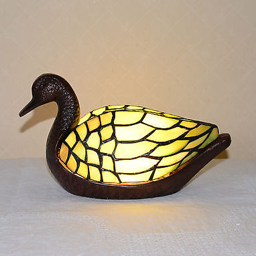

7738.png


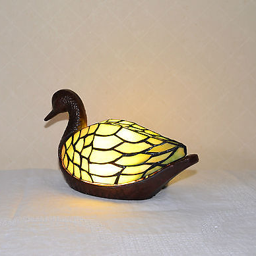

8592.png


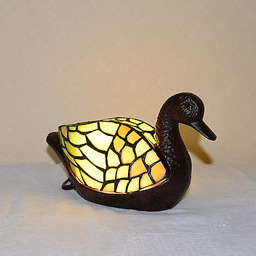

5916.png


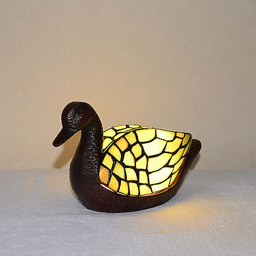

In [29]:
target = '1010.png'
img = Image.open(os.path.join(image_folder,target))
print("Target", target)
display(img)
for img_name in dict_sim[target]:
    print(img_name)
    img = Image.open(os.path.join(image_folder, img_name))
    display(img)